In [ ]:
cd /content/drive/My Drive/Colab Notebooks/MaskRCNN_brain_mri

/content/drive/My Drive/Colab Notebooks/MaskRCNN_brain_mri


In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ij9_gcqk
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ij9_gcqk
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266462 sha256=b826762d6288d6db418d5ac0f6878348a30f5c09767287285b10d45d242ab44c
  Stored in directory: /tmp/pip-ephem-wheel-cache-rb3_g5pf/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.1
    Uninstalling pycocotools-2.0.1:
      Successfully uninstalled pycocotools-2.0.1


In [ ]:
import re
import numpy as np
import cv2
import torch
import torch.utils.data as data
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(img):
  plt.imshow(img)
  plt.show()

In [ ]:
import os.path as osp
from dataloader import make_datapath_list, BrainDataset, get_transform

rootpath = osp.abspath("")
makepath = make_datapath_list(rootpath)
test_img_list, test_anno_list = makepath.get_list("test")

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model = get_instance_segmentation_model(num_classes)

net_weights = torch.load('/content/drive/My Drive/Colab Notebooks/MaskRCNN_brain_mri/weights/maskrcnn_resnet50_fpn_15.pth',
                         map_location={'cuda:0': 'cpu'})
model.load_state_dict(net_weights)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [ ]:
dataset = BrainDataset(test_img_list, test_anno_list, get_transform(train=False))

In [ ]:
class eval_brain():
  def __init__(self, dataset, test_anno_list, model, device):
    self.dataset = dataset
    self.test_anno_list = test_anno_list
    self.model = model
    self.device = device

  def make_result_mask(self, index):
    img, _ = self.dataset[index]
    # put the model in evaluation mode
    self.model.eval()
    with torch.no_grad():
        prediction = model([img.to(self.device)])

    anno_path = self.test_anno_list[index]
    gt_mask = cv2.imread(anno_path, 0)
    gt_mask = np.where(gt_mask==255, 1, 0)

    threshlod = 0.6
    pred_mask = np.zeros((gt_mask.shape))
    if len(prediction[0]['scores']) != 0:
      for i in range(len(prediction[0]['scores'])):
        score = prediction[0]['scores'][i].cpu().numpy()
        if score >= threshlod:
          pred = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
          pred_mask[np.where(pred>=50)] = np.array([1])

    return pred_mask, gt_mask

  def IoU(self, index):
    pred_mask, truth_mask = self.make_result_mask(index)   

    tp = np.count_nonzero((truth_mask ==1) & (pred_mask == 1))
    tn = np.count_nonzero((truth_mask ==0) & (pred_mask == 0))
    fn = np.count_nonzero((truth_mask ==1) & (pred_mask == 0))
    fp = np.count_nonzero((truth_mask ==0) & (pred_mask == 1))

    if (tp + fp + fn) == 0:
      iou = 100
      detect = 'All_TN'
    elif tp == 0 and fp == 0:
      iou = tp/(tp + fp + fn)*100
      detect = 'No_detect'
    elif tp == 0 and fn == 0:
      iou = tp/(tp + fp + fn)*100
      detect = 'Mis_detect'
    else:
      iou = tp/(tp + fp + fn)*100
      if iou == 0:
        detect = "NoMis_detect"
      else:
        detect = 'Detect'
    return iou, detect

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


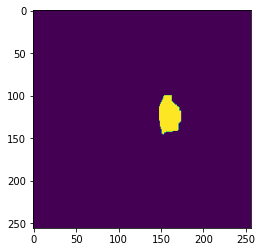

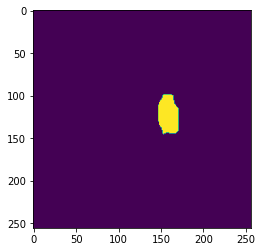

In [ ]:
eval_class = eval_brain(dataset, test_anno_list, model, device)
pred_mask, gt_mask = eval_class.make_result_mask(20)
show_image(gt_mask)
show_image(pred_mask)

In [ ]:
iou, detect = eval_class.IoU(20)
print(iou, detect)

83.80281690140845 Detect


In [ ]:
index = [] 
result_iou = []
columns = ["iou", 'detect']
count_no_detect = 0
count_mis_detect = 0
sum_iou = 0
count = 0
for i, img_path in enumerate(test_img_list):
  add_path = img_path.split('/')[-1]
  iou, detect = eval_class.IoU(i)
  if detect == "Detect":
    sum_iou += iou
    count += 1
  elif detect == "No_detect":
    count_no_detect += 1
  elif detect == "Mis_detect":
    count_mis_detect += 1
  elif detect == "NoMis_detect":
    count_no_detect += 1
    count_mis_detect += 1

  iou = str(iou)
  index.append(add_path)
  result_iou.append([iou, detect])

  print('Number:', i, 'IoU:', iou, "detect:", detect)
print('Average IoU:', sum_iou/count)
index.append("avg iou")
result_iou.append([str(sum_iou/count), ''])

Number: 0 IoU: 100 detect: All_TN
Number: 1 IoU: 100 detect: All_TN
Number: 2 IoU: 100 detect: All_TN
Number: 3 IoU: 100 detect: All_TN
Number: 4 IoU: 100 detect: All_TN
Number: 5 IoU: 100 detect: All_TN
Number: 6 IoU: 100 detect: All_TN
Number: 7 IoU: 100 detect: All_TN
Number: 8 IoU: 100 detect: All_TN
Number: 9 IoU: 100 detect: All_TN
Number: 10 IoU: 100 detect: All_TN
Number: 11 IoU: 100 detect: All_TN
Number: 12 IoU: 100 detect: All_TN
Number: 13 IoU: 100 detect: All_TN
Number: 14 IoU: 100 detect: All_TN
Number: 15 IoU: 11.452031114952463 detect: Detect
Number: 16 IoU: 34.80565371024735 detect: Detect
Number: 17 IoU: 67.34434561626429 detect: Detect
Number: 18 IoU: 79.00128040973111 detect: Detect
Number: 19 IoU: 83.8477366255144 detect: Detect
Number: 20 IoU: 83.80281690140845 detect: Detect
Number: 21 IoU: 89.03394255874673 detect: Detect
Number: 22 IoU: 100 detect: All_TN
Number: 23 IoU: 66.02914389799636 detect: Detect
Number: 24 IoU: 87.71220695230396 detect: Detect
Number: 2

In [ ]:
import pandas as pd
df = pd.DataFrame(result_iou)
df.columns = columns
df.index = index
df.to_csv("maskrcnn_result_per_image.csv")

In [ ]:
result_index = ["avg_iou", "No_detect", "Mis_detect", "Recall", "Precision"]
avg_iou = (sum_iou/count)

recall = count / (count + count_no_detect)
precision = count / (count + count_mis_detect)
result = [avg_iou, count_no_detect, count_mis_detect, recall, precision]
df = pd.DataFrame(result)
df.index = result_index
df.to_csv("maskrcnn_result.csv")